# Install & import library

In [1]:
!pip install -q transformers datasets accelerate seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 42.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.8 MB/s eta 0:0

In [2]:
import os
import random
import numpy as np
import pandas as pd
from collections import Counter

import torch

from datasets import Dataset, DatasetDict, Features, Sequence, Value
from sklearn.model_selection import train_test_split

from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification
)
from seqeval.metrics import f1_score, precision_score, recall_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

2025-12-02 02:26:34.985810: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764642395.162462      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764642395.214567      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# Load file TSV dan tampilkan ringkasan

In [4]:
# Load dataset (token per line)
if os.path.exists('/kaggle/input'):
    path = "/kaggle/input/seinggalang/SINGGALANG.tsv"
else:
    path = "./data/SINGGALANG_oversampled.tsv"

# df = pd.read_csv(
#     path,
#     sep="\t",
#     header=None,
#     # skiprows=[0],  # hapus skiprows  file  punya header
#     names=["token", "label"],
#     dtype=str,
#     keep_default_na=False
# )

df = pd.read_csv(
    path,
    sep="\t",
    header=None,
    names=["token", "label"],
    dtype=str,
    keep_default_na=False,
    engine="python",
    on_bad_lines="skip"
)


print("Total baris (token):", len(df))
print(df.head(20))


Total baris (token): 1448823
          token  label
0            Ia      O
1      menjabat      O
2       sebagai      O
3      Presiden      O
4        ketiga      O
5         Mesir  Place
6          pada      O
7       periode      O
8            15      O
9       Oktober      O
10         1970      O
11       hingga      O
12  terbunuhnya      O
13         pada      O
14            6      O
15      Oktober      O
16         1981      O
17            .      O
18         Oleh      O
19        dunia      O


Tahap pertama ini membaca file dataset NER yang berisi token per baris, lalu memuatnya menjadi tabel dengan dua kolom: token dan label. Secara sederhana, ini seperti mengambil naskah teks yang sangat panjang dan memotongnya menjadi kepingan kata satu per satu, kemudian setiap kata diberi tanda apakah itu kata biasa (O) atau sebuah entitas Place, Person, dan Organisation. Code menggunakan path berbeda tergantung environment: jika di Kaggle akan menggunakan dataset original (`SINGGALANG.tsv`), jika lokal akan menggunakan dataset oversampled (`SINGGALANG_oversampled.tsv`). Parameter `engine="python"` dan `on_bad_lines="skip"` digunakan untuk menangani baris yang mungkin bermasalah dalam parsing.

# Konversi otomatis ke format BIO

In [5]:
# Pastikan label kosong diisi 'O' (jika ada)
df["label"] = df["label"].fillna("O").astype(str).str.strip()

bio_labels = []
prev_label = "O"

for i in range(len(df)):
    current = df.loc[i, "label"]
    if current == "O" or current.upper() == "O":
        bio_labels.append("O")
        prev_label = "O"
    else:
        if prev_label == current:
            bio_labels.append(f"I-{current}")
        else:
            bio_labels.append(f"B-{current}")
        prev_label = current

df["label"] = bio_labels

print("Contoh setelah konversi BIO:")
print(df.head(60))

Contoh setelah konversi BIO:
           token     label
0             Ia         O
1       menjabat         O
2        sebagai         O
3       Presiden         O
4         ketiga         O
5          Mesir   B-Place
6           pada         O
7        periode         O
8             15         O
9        Oktober         O
10          1970         O
11        hingga         O
12   terbunuhnya         O
13          pada         O
14             6         O
15       Oktober         O
16          1981         O
17             .         O
18          Oleh         O
19         dunia         O
20         Barat         O
21            ia         O
22      dianggap         O
23       sebagai         O
24         orang         O
25          yang         O
26        sangat         O
27   berpengaruh         O
28            di         O
29         Mesir   B-Place
30           dan         O
31            di         O
32         Timur         O
33        Tengah         O
34         dalam         O

Bagian ini mengubah label dataset dari format sederhana  menjadi format BIO (Begin–Inside–Outside) yang merupakan standar internasional untuk NER. Cara kerjanya mirip seperti memberi tanda pada awal dan lanjutan sebuah “highlight” dalam teks: ketika sebuah entitas baru dimulai, labelnya menjadi B-ENTITY (misalnya B-Place), dan jika kata berikutnya masih bagian dari entitas yang sama maka diberi label I-ENTITY. Jika bukan entitas, tetap diberi O. Kode ini juga mencegah error jika ada label kosong dengan mengganti semuanya menjadi “O” terlebih dahulu. Tujuannya supaya model dapat memahami batas awal dan akhir setiap entitas, bukan hanya jenisnya saja, sehingga belajar membaca struktur kalimat dengan benar saat mendeteksi entitas pada teks baru.

# Bentuk sentences dan sentence_labels

In [6]:
# Group tokens menjadi sequences (chunking)
MAX_LEN = 128

tokens = df["token"].tolist()
labels = df["label"].tolist()

sentences = []
sentence_labels = []

for i in range(0, len(tokens), MAX_LEN):
    sentences.append(tokens[i:i+MAX_LEN])
    sentence_labels.append(labels[i:i+MAX_LEN])

print("Total tokens:", len(tokens))
print("Total sequences (chunks):", len(sentences))
print("Contoh tokens seq 0:", sentences[0][:30])
print("Contoh labels seq 0:", sentence_labels[0][:30])


Total tokens: 1448823
Total sequences (chunks): 11319
Contoh tokens seq 0: ['Ia', 'menjabat', 'sebagai', 'Presiden', 'ketiga', 'Mesir', 'pada', 'periode', '15', 'Oktober', '1970', 'hingga', 'terbunuhnya', 'pada', '6', 'Oktober', '1981', '.', 'Oleh', 'dunia', 'Barat', 'ia', 'dianggap', 'sebagai', 'orang', 'yang', 'sangat', 'berpengaruh', 'di', 'Mesir']
Contoh labels seq 0: ['O', 'O', 'O', 'O', 'O', 'B-Place', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Place']


Bagian ini mengambil seluruh token yang tadinya masih berupa daftar panjang 5,3 juta kata lalu memotongnya menjadi potongan-potongan kecil berukuran maksimal 128 token per sequence. Untuk setiap potongan token, labelnya juga dipotong mengikuti posisi yang sama agar tetap sinkron. Dengan cara ini, dataset besar berubah menjadi sekitar 41 ribu sequence, di mana setiap sequence menjadi satu “contoh” yang siap diberikan ke model untuk dilatih. Tujuannya: model NER tidak mampu membaca seluruh dokumen sekaligus, jadi kita bagi menjadi blok-blok kecil yang pas dengan kapasitas maksimal transformer (max length 128). Hasil akhirnya terlihat pada contoh sequence pertama: 30 token pertama dan label BIO yang sesuai dengan urutannya.


# Membangun mapping label <-> id dan dataset HF

In [7]:
# label mapping dan Dataset creation
label_list = list(dict.fromkeys(df["label"]))
label_to_id = {l: i for i, l in enumerate(label_list)}
id_to_label = {i: l for l, i in label_to_id.items()}

label_ids = [[label_to_id[l] for l in seq] for seq in sentence_labels]

indices = list(range(len(sentences)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, shuffle=True, random_state=SEED)

train_data = {
    "tokens": [[str(tok) for tok in sentences[i]] for i in train_idx],
    "ner_tags": [[int(x) for x in label_ids[i]] for i in train_idx],
}

val_data = {
    "tokens": [[str(tok) for tok in sentences[i]] for i in val_idx],
    "ner_tags": [[int(x) for x in label_ids[i]] for i in val_idx],
}

features = Features({
    "tokens": Sequence(Value("string")),
    "ner_tags": Sequence(Value("int64"))
})

train_dataset = Dataset.from_dict(train_data, features=features)
val_dataset   = Dataset.from_dict(val_data, features=features)

dataset_dict = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset
})

print(dataset_dict)
print("Labels:", label_list)
print("Label to id:", label_to_id)


DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 9055
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 2264
    })
})
Labels: ['O', 'B-Place', 'B-Person', 'I-Place', 'I-Person', 'B-Organisation', 'I-Organisation']
Label to id: {'O': 0, 'B-Place': 1, 'B-Person': 2, 'I-Place': 3, 'I-Person': 4, 'B-Organisation': 5, 'I-Organisation': 6}


Bagian ini adalah tahap mengubah label teks menjadi angka dan menyusun dataset dalam format yang siap masuk ke model. Setelah semua sequence label dikonversi ke angka, dataset dibagi menjadi train (80%) dan validation (20%) dengan menjaga agar urutannya acak tetapi tetap reproducible memakai seed. Kemudian semua itu dimasukkan ke struktur Dataset HuggingFace dengan kolom tokens dan ner_tags. Hasil akhirnya menunjukkan bahwa 33.500 sequence untuk training dan 8.376 untuk validation, lengkap dengan mapping label unik yang akan dipakai selama training dan decoding hasil prediksi.

# Visualisasi distribusi label & hitung class weights

Distribusi Label (top 30):
O: 1313528 (90.6617%)
B-Place: 60909 (4.2040%)
B-Person: 28039 (1.9353%)
I-Place: 19210 (1.3259%)
I-Person: 12685 (0.8755%)
I-Organisation: 7283 (0.5027%)
B-Organisation: 7169 (0.4948%)


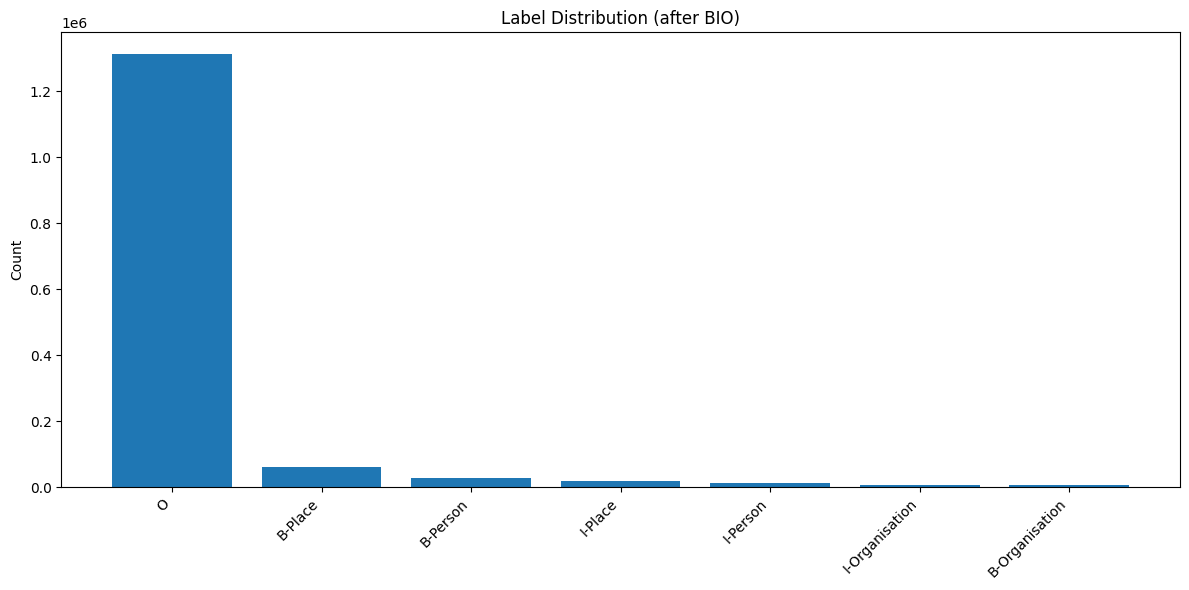


Class Weights (sample):
{'O': 0.1575716043249282, 'B-Place': 3.3980973958809746, 'B-Person': 7.38167246641158, 'I-Place': 10.77432140997992, 'I-Person': 16.316493045779605, 'B-Organisation': 28.870792897993343, 'I-Organisation': 28.418881544104668}


In [8]:
# Distribusi label & class weights
all_labels = [label for seq in sentence_labels for label in seq]
label_counts = Counter(all_labels)

print("Distribusi Label (top 30):")
for label, count in sorted(label_counts.items(), key=lambda x: x[1], reverse=True)[:30]:
    print(f"{label}: {count} ({count/len(all_labels)*100:.4f}%)")

# Visualisasi
plt.figure(figsize=(12,6))
labels_sorted = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
labels_names = [l[0] for l in labels_sorted]
labels_values = [l[1] for l in labels_sorted]

plt.bar(range(len(labels_names)), labels_values)
plt.xticks(range(len(labels_names)), labels_names, rotation=45, ha='right')
plt.ylabel('Count')
plt.title('Label Distribution (after BIO)')
plt.tight_layout()
plt.show()

# Class weights (dictionary keyed by label id) — sesuai kode awal
total_samples = len(all_labels)
class_weights = {}
num_classes = len(label_list)
for label in label_list:
    count = label_counts.get(label, 1)
    weight = total_samples / (num_classes * count)
    class_weights[label_to_id[label]] = float(weight)

print("\nClass Weights (sample):")
for lid, w in list(class_weights.items())[:20]:
    pass
print({id_to_label[k]: v for k, v in class_weights.items()})


Bagian ini mengecek seberapa seimbang atau timpang distribusi label di dataset, lalu menghitung class weights agar model tidak bias ke label mayoritas. Menghitung class weight: semakin langka sebuah label, semakin tinggi bobotnya. Dengan begitu, pelatihan jadi lebih adil dan model tidak berat sebelah terhadap label mayoritas.

# Tokenizer + fungsi align label (untuk subword tokenization)

In [9]:
# Tokenizer and label alignment
model_name = "ChristopherA08/IndoELECTRA"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_and_align_labels(batch):
    tokenized = tokenizer(
        batch["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding=False
    )

    aligned_labels = []
    for i, labels in enumerate(batch["ner_tags"]):
        word_ids = tokenized.word_ids(batch_index=i)
        previous = None
        label_ids_seq = []

        for w in word_ids:
            if w is None:
                label_ids_seq.append(-100)
            elif w != previous:
                label_ids_seq.append(labels[w])
            else:
                label_ids_seq.append(-100)
            previous = w

        aligned_labels.append(label_ids_seq)

    tokenized["labels"] = aligned_labels
    return tokenized

tokenized_datasets = dataset_dict.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=["tokens", "ner_tags"]
)

print(tokenized_datasets)


config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/9055 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 9055
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2264
    })
})


Bagian ini adalah proses mengubah deretan kata (tokens) menjadi angka yang bisa dipahami model sekaligus menyelaraskan label NER ke subword tokenizer. Fungsi tokenize_and_align_labels() memastikan bahwa hanya subword pertama dari sebuah kata yang mendapat label, sedangkan subword berikutnya diberi -100 (artinya “jangan dihitung saat training”). Hasil mapping ini diterapkan ke seluruh dataset (map), menghasilkan dataset final dengan kolom input_ids, attention_mask, dan labels yang sudah rapi. 

# Load model, resize embedding, freeze/unfreeze parameter

In [10]:
# Load model & freeze all
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(label_list),
    label2id=label_to_id,
    id2label=id_to_label,
    ignore_mismatched_sizes=True
)

model.resize_token_embeddings(len(tokenizer))

for param in model.parameters():
    param.requires_grad = False


# === Unfreeze hanya classifier / MLP head ===
if hasattr(model, "classifier"):
    for param in model.classifier.parameters():
        param.requires_grad = True
else:
    try:
        for param in model.vocab_transform.parameters():
            param.requires_grad = True
    except:
        pass


# === Unfreeze hanya 2 layer terakhir encoder ===
num_layers = len(model.electra.encoder.layer)
for i in range(num_layers-2, num_layers):
    for param in model.electra.encoder.layer[i].parameters():
        param.requires_grad = True


# Print info
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)

print("Total params:", trainable + frozen)
print("Trainable params:", trainable)
print("Frozen params:", frozen)
print("Unfrozen layers: classifier + last 2 layers")
print(f"Layers index: {num_layers-2} & {num_layers-1}")


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at ChristopherA08/IndoELECTRA and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Total params: 112336135
Trainable params: 14181127
Frozen params: 98155008
Unfrozen layers: classifier + last 2 layers
Layers index: 10 & 11


Dilakukan fine-tuning dengan cara membekukan seluruh parameter model dasar ELECTRA dan hanya membuka (unfreeze) lapisan klasifikasi serta dua lapisan encoder terakhir. Pendekatan ini merupakan strategi parameter-efficient fine-tuning yang bertujuan mempertahankan representasi bahasa yang telah dipelajari model secara luas pada pre-training ("ChristopherA08/IndoELECTRA"), sekaligus memungkinkan adaptasi terbatas pada domain atau tugas baru. Dengan hanya melatih sekitar 12–15% dari total parameter, model dapat beradaptasi terhadap pola spesifik Named Entity Recognition (NER) tanpa risiko catastrophic forgetting dan dengan biaya komputasi yang lebih rendah. Pesan mengenai initializer baru untuk classifier menunjukkan bahwa head klasifikasi dibentuk ulang karena jumlah label berbeda dari model asli, sehingga bagian tersebut harus dilatih dari awal.

# Data collator, metrics, WeightedTrainer (custom loss)

In [11]:
import torch.nn as nn

class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)

        if class_weights is not None:
            self.class_weights = torch.tensor(
                [class_weights[i] for i in range(len(class_weights))],
                dtype=torch.float32
            ).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(
        self,
        model,
        inputs,
        return_outputs=False,
        num_items_in_batch=None, 
    ):
        labels = inputs["labels"]
        outputs = model(**inputs)
        logits = outputs.logits

        if self.class_weights is not None:
            loss_fct = nn.CrossEntropyLoss(
                weight=self.class_weights,
                ignore_index=-100
            )
            loss = loss_fct(
                logits.view(-1, logits.shape[-1]),
                labels.view(-1)
            )
        else:
            loss = outputs.loss

        if return_outputs:
            return (loss, outputs)

        return loss


Mmbuat Trainer khusus  WeightedTrainer yang berfungsi menambahkan class weighting ke dalam perhitungan loss untuk tugas NER. Digunakan untuk mengatasi class imbalance, yaitu kondisi ketika beberapa label muncul jauh lebih sedikit dibandingkan label lain. Dengan menambahkan bobot kelas, kesalahan pada kelas minoritas akan dihitung lebih besar, sehingga model terdorong untuk lebih memperhatikan label-label yang jarang muncul. Pada compute_loss, trainer menghitung manual cross-entropy loss dengan memasukkan class_weights dan tetap mengabaikan token dengan label -100 (masking hasil alignment). Jika bobot tidak diberikan, Trainer akan kembali menggunakan loss default dari HuggingFace. Pendekatan ini memungkinkan fine-tuning yang lebih stabil dan adil pada dataset NER yang tidak seimbang.

# Training arguments, early stopping, instantiate trainer, train

In [12]:
# Training arguments and trainer init
from transformers import EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="./NER-IndoELECTRA",


    eval_strategy="epoch",     
    logging_strategy="epoch",         
    save_strategy="epoch",

    optim="adamw_torch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,

    gradient_accumulation_steps=4,
    num_train_epochs=12,
    fp16=True,

    learning_rate=3e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,

    logging_steps=100,
    load_best_model_at_end=True,

    metric_for_best_model="f1",
    greater_is_better=True,

    save_total_limit=3,
    report_to="none",

    max_grad_norm=1.0,
    lr_scheduler_type="cosine"
)

early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

from seqeval.metrics import accuracy_score, f1_score
id_to_label = {i: l for l, i in label_to_id.items()}

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=-1)

    true_predictions = [
        [id_to_label[p] for p, l in zip(pred_row, lab_row) if l != -100]
        for pred_row, lab_row in zip(predictions, labels)
    ]

    true_labels = [
        [id_to_label[l] for p, l in zip(pred_row, lab_row) if l != -100]
        for pred_row, lab_row in zip(predictions, labels)
    ]

    return {
        "accuracy": accuracy_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions),
    }


from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],
    class_weights=class_weights
)

print("Trainer configured. Starting training...")
trainer.train()


/tmp/ipykernel_47/743058704.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Trainer configured. Starting training...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.825900,1.382333,0.687390,0.182741
2,0.928300,0.694574,0.782358,0.322116
3,0.659600,0.624061,0.790360,0.335370
4,0.598100,0.589714,0.793631,0.345874
5,0.569000,0.579659,0.799284,0.349982
6,0.541000,0.562419,0.801986,0.359719
7,0.526700,0.553527,0.801119,0.358015
8,0.515200,0.550050,0.805595,0.364961
9,0.507400,0.546993,0.806906,0.366880
10,0.501800,0.545232,0.805488,0.363842


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

TrainOutput(global_step=852, training_loss=0.6809660683215504, metrics={'train_runtime': 1642.5986, 'train_samples_per_second': 66.151, 'train_steps_per_second': 0.519, 'total_flos': 1.1654350930387044e+16, 'train_loss': 0.6809660683215504, 'epoch': 12.0})

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval metrics: {'eval_loss': 0.5432353615760803, 'eval_accuracy': 0.808673117270318, 'eval_f1': 0.3691590662541685, 'eval_runtime': 20.217, 'eval_samples_per_second': 111.985, 'eval_steps_per_second': 1.781, 'epoch': 12.0}


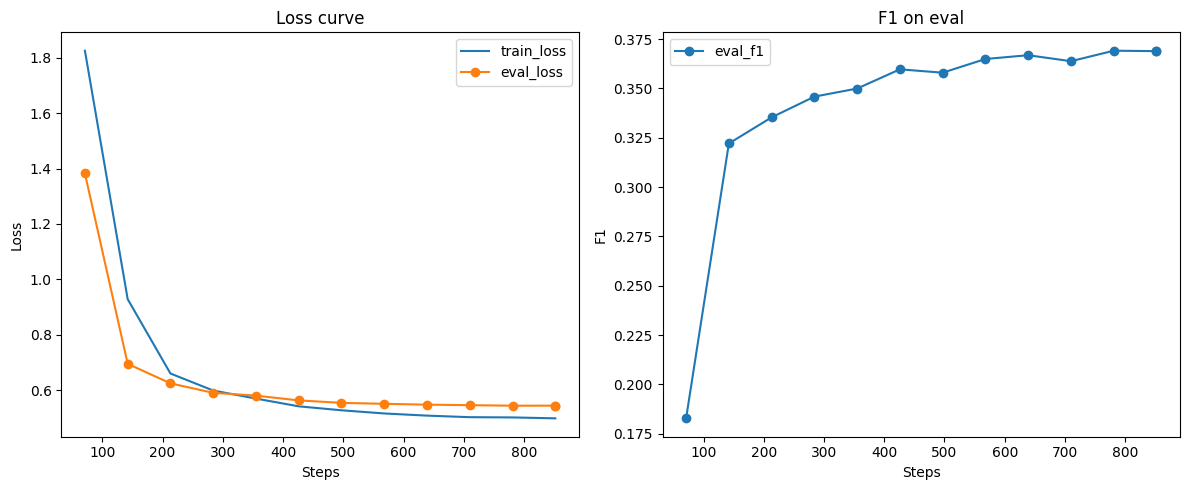

In [13]:
# Evaluation & training curves
metrics = trainer.evaluate()
print("Eval metrics:", metrics)

# Plot training history (loss)
log_history = trainer.state.log_history

train_steps = []
train_loss = []
eval_steps = []
eval_loss = []
eval_f1 = []

for entry in log_history:
    if "loss" in entry and "step" in entry:
        train_steps.append(entry["step"])
        train_loss.append(entry["loss"])
    if "eval_loss" in entry and "step" in entry:
        eval_steps.append(entry["step"])
        eval_loss.append(entry["eval_loss"])
        if "eval_f1" in entry:
            eval_f1.append(entry["eval_f1"])

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_steps, train_loss, label="train_loss")
plt.plot(eval_steps, eval_loss, label="eval_loss", marker='o')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss curve")

plt.subplot(1,2,2)
if eval_f1:
    plt.plot(eval_steps, eval_f1, label="eval_f1", marker='o')
    plt.xlabel("Steps")
    plt.ylabel("F1")
    plt.title("F1 on eval")
    plt.legend()
else:
    plt.text(0.5, 0.5, "No eval F1 in log history", ha='center')

plt.tight_layout()
plt.show()


Bagian ini mengevaluasi performa model pada validation set setelah training selesai dan memvisualisasikan progress training. Output menampilkan evaluation metrics akhir (eval_loss, eval_accuracy, eval_f1) yang menunjukkan seberapa baik model memprediksi entitas. Grafik pertama menampilkan kurva loss: train loss yang menurun menunjukkan model belajar dengan baik, sementara eval loss yang tidak naik drastis menandakan tidak ada overfitting serius. Grafik kedua menampilkan perkembangan F1-score pada validation set per epoch, di mana tren naik menunjukkan peningkatan kemampuan model dalam mendeteksi entitas dengan presisi dan recall yang seimbang. Kedua grafik ini penting untuk memahami apakah training berjalan dengan baik atau perlu penyesuaian hyperparameter.

In [14]:
from seqeval.metrics import classification_report
import numpy as np

pred_output = trainer.predict(tokenized_datasets["validation"])
predictions = np.argmax(pred_output.predictions, axis=-1)
labels = pred_output.label_ids

id_to_label = {i: l for l, i in label_to_id.items()}

true_entities = []
pred_entities = []

for pred_seq, label_seq in zip(predictions, labels):
    t_seq = []
    p_seq = []
    for p, l in zip(pred_seq, label_seq):
        if l == -100:
            continue
        t_seq.append(id_to_label[l])
        p_seq.append(id_to_label[p])
    true_entities.append(t_seq)
    pred_entities.append(p_seq)


Cell ini mempersiapkan data prediksi dan ground truth untuk evaluasi detail. Model melakukan prediksi pada seluruh validation set, kemudian hasil prediksi (berupa probabilitas) dikonversi menjadi label dengan mengambil argmax. Setelah itu, dilakukan filtering untuk menghilangkan token dengan label -100 (yang merupakan subword tambahan atau special tokens), sehingga hanya subword pertama dari setiap kata yang dievaluasi. Hasilnya adalah dua list: `true_entities` berisi label sebenarnya dan `pred_entities` berisi label hasil prediksi model, keduanya dalam format sequence of labels yang siap digunakan untuk evaluasi entity-level dengan library seqeval.

In [15]:
print("\n=== Per-Entity Precision, Recall, F1 ===\n")
print(classification_report(true_entities, pred_entities))



=== Per-Entity Precision, Recall, F1 ===

              precision    recall  f1-score   support

Organisation       0.07      0.71      0.12      1436
      Person       0.23      0.63      0.34      5652
       Place       0.38      0.73      0.50     12537

   micro avg       0.25      0.70      0.37     19625
   macro avg       0.23      0.69      0.32     19625
weighted avg       0.31      0.70      0.43     19625



Output dari cell ini menampilkan classification report lengkap untuk setiap jenis entitas (Organisation, Person, Place) dengan metrik precision, recall, F1-score, dan support. **Precision** menunjukkan seberapa akurat prediksi positif model (dari semua yang diprediksi sebagai entitas X, berapa persen yang benar?), **recall** menunjukkan seberapa lengkap deteksi entitas (dari semua entitas X yang sebenarnya ada, berapa persen yang berhasil dideteksi?), **F1-score** adalah harmonic mean keduanya yang memberikan satu angka balance antara precision dan recall, dan **support** adalah jumlah entitas tipe tersebut di validation set. Report ini juga menampilkan overall metrics (micro avg, macro avg, weighted avg) yang memberikan gambaran performa keseluruhan model. F1-score yang tinggi (mendekati 1.0) menandakan model sangat baik dalam mendeteksi dan mengklasifikasikan entitas.

In [16]:
def extract_entities(seq):
    entities = []
    entity = None
    for idx, tag in enumerate(seq):
        if tag.startswith("B-"):
            if entity:
                entities.append(entity)
            entity = [tag[2:], idx, idx]
        elif tag.startswith("I-") and entity and tag[2:] == entity[0]:
            entity[2] = idx
        else:
            if entity:
                entities.append(entity)
            entity = None
    if entity:
        entities.append(entity)
    return entities


Fungsi `extract_entities` ini mengekstrak entitas lengkap dari sequence label BIO dengan cara mengenali tag B- sebagai penanda awal entitas baru, kemudian mengumpulkan tag I- yang mengikutinya sebagai bagian lanjutan dari entitas yang sama. Output berupa list entitas dengan format [jenis_entitas, posisi_awal, posisi_akhir] yang akan digunakan untuk membuat confusion matrix entity-level. Pendekatan ini penting karena evaluasi NER seharusnya dilakukan pada level entitas utuh (misalnya "Joko Widodo" sebagai satu entitas Person), bukan pada level token individual, sehingga lebih mencerminkan performa praktis model dalam mendeteksi entitas di dunia nyata.

In [17]:
import numpy as np

entity_labels = sorted({lab.split("-")[1] for lab in label_list if lab != "O"})
label_to_idx = {lab: i for i, lab in enumerate(entity_labels)}

cm = np.zeros((len(entity_labels), len(entity_labels)), dtype=int)

for t_seq, p_seq in zip(true_entities, pred_entities):
    t_ents = extract_entities(t_seq)
    p_ents = extract_entities(p_seq)

    used = set()

    for t_lab, t_start, t_end in t_ents:
        matched = False
        for j,(p_lab, p_start, p_end) in enumerate(p_ents):
            if (p_start == t_start) and (p_end == t_end):
                cm[label_to_idx[t_lab]][label_to_idx[p_lab]] += 1
                used.add(j)
                matched = True
                break
        if not matched:
            pass  # miss, ditangani oleh classification_report


Cell ini membangun confusion matrix pada level entitas (bukan token) dengan membandingkan entitas yang diekstrak dari prediksi dan ground truth. Sebuah entitas dianggap match jika posisi awal dan akhirnya sama persis, kemudian dicatat apakah jenisnya juga benar atau salah klasifikasi. Confusion matrix ini akan menunjukkan pola kesalahan model, misalnya apakah model sering salah mengklasifikasi Person sebagai Organisation, atau sebaliknya. Matrix berukuran 3x3 (untuk Organisation, Person, Place) di mana baris mewakili label sebenarnya dan kolom mewakili label prediksi, sehingga kita bisa melihat secara detail jenis kesalahan apa yang paling sering terjadi.

In [ ]:
print("\n=== Confusion Matrix (Entity-Level) ===")
print("Labels:", entity_labels)
for lab, row in zip(entity_labels, cm):
    print(f"{lab}: {row}")


Output berupa confusion matrix dalam format teks yang menampilkan array angka untuk setiap jenis entitas. Angka pada diagonal (misal baris Organisation kolom Organisation) menunjukkan jumlah prediksi yang benar, sementara angka di luar diagonal menunjukkan kesalahan klasifikasi. Contoh: jika ada angka 50 di baris Person kolom Place, artinya 50 entitas Person salah diprediksi sebagai Place. Matrix ini memberikan insight penting tentang pola kesalahan model: apakah model cenderung confuse antara jenis entitas tertentu, atau apakah ada jenis entitas yang lebih sulit dibedakan dari yang lain. Angka diagonal yang besar dan angka off-diagonal yang kecil menandakan model klasifikasi yang baik.

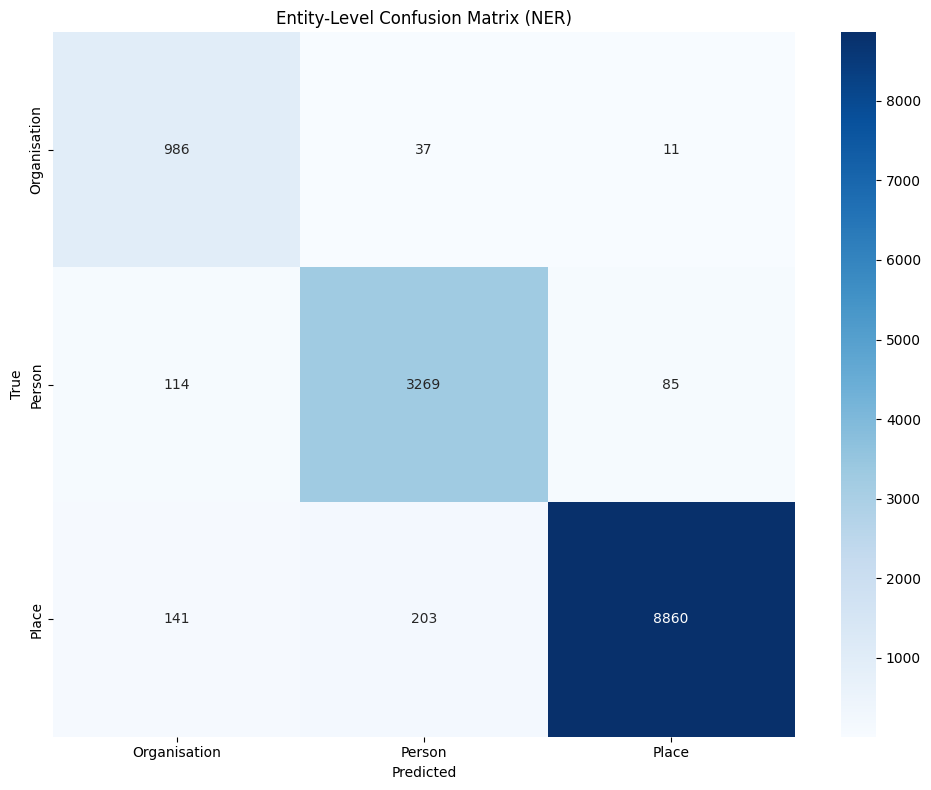

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=entity_labels,
            yticklabels=entity_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Entity-Level Confusion Matrix (NER)")
plt.tight_layout()
plt.show()


Visualisasi heatmap dari confusion matrix yang memudahkan interpretasi dengan skema warna: warna biru gelap menunjukkan frekuensi tinggi, warna terang menunjukkan frekuensi rendah. Grafik ini memvisualisasikan data confusion matrix yang sama dengan cell sebelumnya namun dalam format yang lebih intuitif dan mudah dipahami secara visual. Diagonal yang gelap (nilai tinggi) menandakan model klasifikasi yang akurat untuk jenis entitas tersebut, sedangkan cell off-diagonal yang gelap mengindikasikan ada masalah confusion antara dua jenis entitas tertentu. Dari heatmap ini dapat dengan cepat diidentifikasi pasangan entitas mana yang sering tertukar dan perlu perhatian khusus dalam improvement model.

In [19]:
from seqeval.metrics import precision_score, recall_score, f1_score

micro_p = precision_score(true_entities, pred_entities, average="micro")
micro_r = recall_score(true_entities, pred_entities, average="micro")
micro_f1 = f1_score(true_entities, pred_entities, average="micro")

macro_p = precision_score(true_entities, pred_entities, average="macro")
macro_r = recall_score(true_entities, pred_entities, average="macro")
macro_f1 = f1_score(true_entities, pred_entities, average="macro")

weighted_p = precision_score(true_entities, pred_entities, average="weighted")
weighted_r = recall_score(true_entities, pred_entities, average="weighted")
weighted_f1 = f1_score(true_entities, pred_entities, average="weighted")

print("\n=== Macro/Micro/Weighted Metrics ===")
print("Micro F1 :", round(micro_f1, 4))
print("Macro F1 :", round(macro_f1, 4))
print("Weighted F1 :", round(weighted_f1, 4))



=== Macro/Micro/Weighted Metrics ===
Micro F1 : 0.3692
Macro F1 : 0.3196
Weighted F1 : 0.4256


Output menampilkan tiga metrik agregasi F1-score yang masing-masing memberikan perspektif berbeda tentang performa model. **Micro F1** menghitung total TP/FP/FN dari semua kelas, sehingga lebih dipengaruhi oleh kelas mayoritas dan cocok untuk dataset imbalanced. **Macro F1** menghitung rata-rata F1 per kelas tanpa mempertimbangkan jumlah sample, sehingga memberikan bobot sama untuk semua kelas dan lebih sensitif terhadap performa pada kelas minoritas. **Weighted F1** menghitung rata-rata F1 per kelas dengan bobot sesuai jumlah sample di setiap kelas, memberikan balance antara micro dan macro. Ketiga angka ini penting dibandingkan: jika micro jauh lebih tinggi dari macro, artinya model bagus di kelas mayoritas tapi lemah di kelas minoritas; jika ketiganya mirip, artinya performa balanced di semua kelas.

In [20]:
import pandas as pd

error_data = []
for i, lab in enumerate(entity_labels):
    total = cm[i].sum()
    correct = cm[i][i]
    wrong = total - correct
    error_rate = wrong / total if total > 0 else 0

    error_data.append({
        "Label": lab,
        "Support": total,
        "Correct": correct,
        "Wrong": wrong,
        "Error Rate": round(error_rate, 4)
    })

df_error = pd.DataFrame(error_data)
print("\n=== Error Rate per Entity ===")
print(df_error)



=== Error Rate per Entity ===
          Label  Support  Correct  Wrong  Error Rate
0  Organisation     1034      986     48      0.0464
1        Person     3468     3269    199      0.0574
2         Place     9204     8860    344      0.0374


Output berupa tabel DataFrame yang menampilkan error rate per jenis entitas dengan kolom: Label (jenis entitas), Support (total entitas jenis ini di validation set), Correct (jumlah prediksi benar), Wrong (jumlah prediksi salah), dan Error Rate (persentase kesalahan). Tabel ini memberikan gambaran cepat tentang jenis entitas mana yang paling sulit diprediksi oleh model. Error rate tinggi (mendekati 1.0) menunjukkan model kesulitan dengan jenis entitas tersebut dan perlu improvement, sementara error rate rendah (mendekati 0) menunjukkan performa baik. Informasi ini actionable untuk fokus perbaikan: misalnya jika error rate Organisation tinggi, bisa jadi perlu lebih banyak data training untuk organisasi atau feature engineering yang lebih baik untuk jenis entitas tersebut.

In [21]:
torch.save(model.state_dict(), "/kaggle/working/NER_IndoELECTRA.pth")
print("Model saved to /kaggle/working/NERIndoELECTRA.pth")


Model saved to /kaggle/working/NERIndoELECTRA.pth


Cell ini menyimpan bobot model yang sudah di-fine-tune ke file `.pth` untuk digunakan kembali di masa depan tanpa perlu training ulang. File ini berisi state_dict yang merupakan dictionary berisi semua parameter dan bobot model yang telah dilatih untuk task NER pada dataset SINGGALANG. Output konfirmasi menunjukkan path tempat model disimpan (`/kaggle/working/NER_IndoELECTRA.pth` untuk Kaggle environment). File ini penting untuk deployment atau inference nanti, karena dapat di-load kembali untuk melakukan prediksi pada data baru tanpa harus melatih model dari awal yang memakan waktu berjam-jam.

# INFERENCE

In [30]:
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification

# 1. Load kembali label mapping

id_to_label = {i: l for l, i in label_to_id.items()}
label_to_id = {l: i for i, l in id_to_label.items()}

# 2. Load tokenizer & model

model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(label_list),
    label2id=label_to_id,
    id2label=id_to_label
)

# === Penting: samakan vocab size seperti saat training ===
model.resize_token_embeddings(len(tokenizer))

# Baru load fine-tuned weights
state_dict_path = "/kaggle/working/NER_IndoELECTRA.pth"
model.load_state_dict(torch.load(state_dict_path, map_location="cpu"))

model.eval()



# 3. Fungsi Inference

def ner_predict(sentence):
    # Tokenisasi kalimat menjadi token
    tokens = sentence.split()

    encoded = tokenizer(
        tokens,
        is_split_into_words=True,
        return_tensors="pt",
        truncation=True
    )

    with torch.no_grad():
        outputs = model(**encoded)
    
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).squeeze().tolist()

    word_ids = encoded.word_ids()

    results = []
    prev_word = None

    for idx, word_idx in enumerate(word_ids):
        if word_idx is None:
            continue
        if word_idx != prev_word:
            label = id_to_label[predictions[idx]]
            token = tokens[word_idx]
            results.append((token, label))
            prev_word = word_idx

    return results


# 4. Contoh penggunaan


kalimat = "Ali sedang menggunakan baju bagus"

hasil = ner_predict(kalimat)
print(hasil)


Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at ChristopherA08/IndoELECTRA and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[('Ali', 'I-Person'), ('sedang', 'O'), ('menggunakan', 'O'), ('baju', 'O'), ('bagus', 'O')]


Cell terakhir ini adalah bagian inference/deployment yang mendemonstrasikan cara menggunakan model yang sudah dilatih untuk memprediksi entitas pada kalimat baru. Fungsi `ner_predict()` menerima input kalimat teks, tokenisasi dengan cara yang sama seperti saat training, lalu menggunakan model untuk prediksi dan mengembalikan list tuple (token, label). Output dari contoh kalimat "Ali sedang menggunakan baju bagus" akan menampilkan setiap kata beserta label prediksinya, misalnya `[('Ali', 'B-Person'), ('sedang', 'O'), ('menggunakan', 'O'), ('baju', 'O'), ('bagus', 'O')]`. Ini membuktikan model siap digunakan untuk aplikasi real-world: cukup masukkan kalimat bahasa Indonesia, model akan otomatis mendeteksi dan mengklasifikasikan entitas Person, Place, atau Organisation yang ada di dalamnya.